## Packages
Install necessary packages: numpy, control, and multiprocessing.

In [1]:
!pip install -r requirements.txt -U


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import necessary packages
import re

import numpy as np
import control as ct

from typing import Callable, Tuple

import matplotlib.pyplot as plt

## Plot
Given a transfer function **H**, frequency range **\[start, end\]**, and propagation delay **delay**, we numerically approximate the transfer function given a square wave amplifier, which theoretically produces an infinite number of harmonics. If there is no propagation delay or it is already approximated in the transfer function, **delay** defaults to the floating point ε to approximate the limit form mentioned in Putzey's paper.

In [3]:
from modules.calc_resp import precompute_consts, calc_resp

def calc(
    H: ct.TransferFunction, 
    start: float, 
    end: float, 
    delay=np.finfo(np.longdouble).eps,
    num_freqs=1_000,
    num_duty_cycles=100,
    num_harmonics=100.
) -> Tuple[np.ndarray]:
    consts = list(precompute_consts(num_freqs, num_duty_cycles, num_harmonics, (start, end)))
    
    mags, phs, osc_fs, dcins, dcgains = calc_resp(np.array(H.num[0])[:,::-1], np.array(H.den[0])[:,::-1], np.array([delay]), *consts)
    
    consts[0] = np.imag(consts[0]) / (2 * np.pi)
    osc_fs /= 2 * np.pi
    phs -= np.pi

    return (mags[0], phs[0], osc_fs[0], dcins[0], dcgains[0]), consts[:3]

In [4]:
def plot(
    H: ct.TransferFunction, 
    start: float, 
    end: float, 
    delay=np.finfo(np.longdouble).eps
) -> None:
    """ Takes a SISO transfer function `H` and plots phase response and loop gain vs.
    frequency, oscillation frequency vs. duty cycle, DC transfer curve, and loop gain 
    vs. duty cycle. """

    (mags, phs, osc_fs, dcins, dcgains), (omega, hs, ns) = calc(H, start, end, delay)
    
    # Plotting
    fig, ((ax_ph, ax_dcgain), (ax_osc, ax_dcin)) = plt.subplots(2,2)

    # Set figure labels
    ax_osc.set_ylabel('Osc. Freq. (Hz)')
    ax_osc.set_xlabel('Duty Cycle')

    ax_ph.set_xlabel('Frequency (Hz)')
    ax_ph.set_ylabel('Phase (°)')
    ax_mag = ax_ph.twinx()
    ax_mag.set_ylabel('Magnitude (dB)')

    # Plot phase
    cs = ['b','g','c','y']
    for i, p in enumerate(phs[-1:0:-(hs.size // 5),:]):
        ax_ph.plot(omega, np.degrees(np.unwrap(p)), f'{cs[i % len(cs)]}--')

    ax_ph.plot([start, end], [-180, -180], 'k:')
    ax_ph.set_xscale('log')

    max_ph = max(np.ceil(np.degrees(np.max(phs))), 0) + 10
    ax_ph.set_yticks([0, -180, -360])
    ax_ph.set_ylim(-360-max_ph, max_ph)

    # Plot oscillation frequencies
    ax_osc.plot(
        np.concatenate((hs, 1-hs[-1::-1])),
        np.concatenate((osc_fs, osc_fs[-1::-1]))
    )

    # Plot dcin
    ax_dcin.plot(
        np.concatenate((-dcins, dcins[-1::-1])),
        np.concatenate((2 * hs - 1, - 2 * hs[-1::-1] + 1))
    )

    # Plot dcgain
    ax_dcgain.plot(
        np.concatenate((2 * hs - 1, - 2 * hs[-1::-1] + 1)),
        np.concatenate((dcgains, dcgains[-1::-1]))
    )

    # Plot magnitudes
    mag_scaled = 20 * np.log10(dcgains[-1] * mags[-1])
    ax_mag.plot(omega, mag_scaled, 'r-')
    
    max_mag = round(max(
        *map(
            np.abs, 
            (np.min(mag_scaled), np.max(mag_scaled))
        ), 
        0
    )) + 3
    ax_mag.set_ylim(-max_mag, max_mag)

    fig.tight_layout()



## Transfer Functions

As per Bruno Putzey's 2011 paper titled ["Global Modulated Self-Oscillating Amplifier with Improved Linearity"](https://www.hypex.nl/media/3f/62/4a/1682342035/Globally%20modulated%20self-oscillating%20amplifier.pdf), we treat our Class-D amplifier as a square wave oscillator wrapped with a linear function. For simplicity's sake, we further split said linear function into three serial sections–the **propagation delay**, **low pass filter**, and **feedback network**. The **propagation delay** is calculated during numerical evaluation in order to avoid using a Padé approximation. Please define functions constructing transfer functions based on component values for the **low pass filter** and **feedback network** below.

## Workspace

In [5]:
from modules.sapwin import Sapwin

problem = Sapwin(filename='../sym_analysis/SapWin/class_d_ucd.out', n_fs=5_000, n_ns=500)

In [6]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.lhs import LHS

algorithm = NSGA2(
    pop_size=500,
    n_offsprings=50,
    sampling=LHS(),
    crossover=HalfUniformCrossover(prob=0.8),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

In [7]:
from pymoo.optimize import minimize

res = minimize(
    problem,
    algorithm,
    termination=('n_gen', 100),
    seed=2,
    save_history=True,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      500 |      3 |             - |             -
     2 |      550 |      3 |  0.000000E+00 |             f
     3 |      600 |      3 |  0.000000E+00 |             f
     4 |      650 |      4 |  0.0146571871 |         ideal
     5 |      700 |      6 |  0.4323357440 |         ideal
     6 |      750 |      7 |  0.0000387493 |             f
     7 |      800 |      8 |  0.2854911833 |         ideal
     8 |      850 |      9 |  0.6461584454 |         ideal
     9 |      900 |     11 |  0.0178532283 |             f
    10 |      950 |      8 |  0.0955322106 |         ideal
    11 |     1000 |     10 |  0.6418807333 |         ideal
    12 |     1050 |     11 |  0.0494551059 |             f
    13 |     1100 |      9 |  1.7294985284 |         nadir
    14 |     1150 |     10 |  0.0006037322 |             f
    15 |     1200 |     12 |  0.1691075314 |         nadir
    16 |     1250 |     10 |  0.0260109459 |            

In [8]:
X = res.X
F = res.F

/mnt/c/Users/Aaron/Documents/GitHub/class-d-amp/loop_analysis/python/.venv/lib/python3.12/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


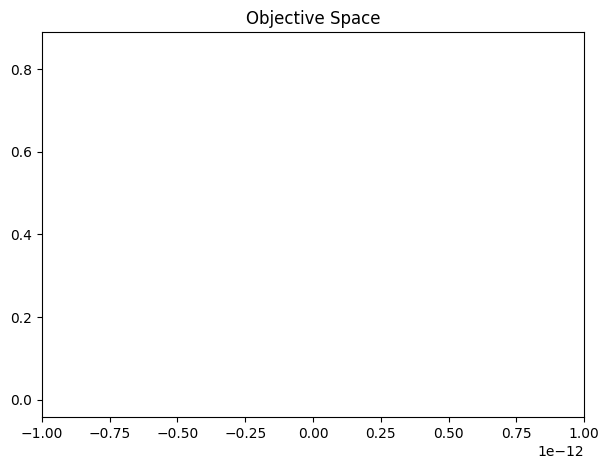

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [10]:
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

Scale f1: [277.549083550286, 1.7976931348623157e+308]
Scale f2: [0.0, 0.846650038629242]


In [21]:
idx = min(range(F.shape[0]), key=lambda i: F[i,1] + F[i,2] + (np.inf if F[i,0] > 40e3 else 0))
idx

417

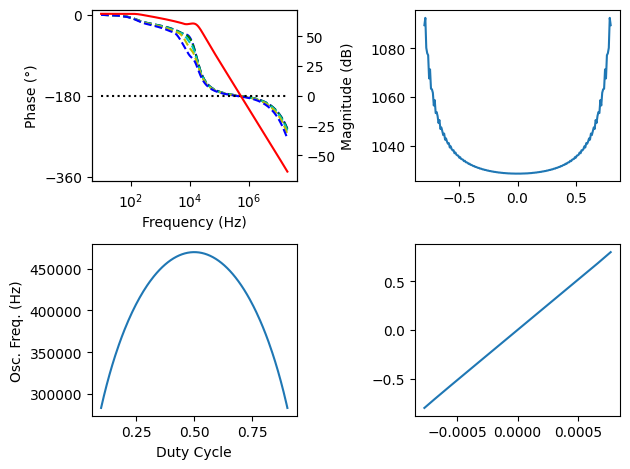

In [22]:
vals = X[idx,:-1][None,:]
delay = X[idx,-1]

problem.evaluate(X[idx][None,:])

num = problem._calc_num(vals)[0,::-1]
den = problem._calc_den(vals)[0,::-1]

plot(ct.tf(num, den), 10, 2e7, delay)